In [2362]:
# ======================================================
# Project: Food Collector
# Authors: Gamaliel Marines Olvera A01708746
#          Juan Pablo Cabrera Quiroga
#          Sebastian Flores  Lemus A01709229
# Description: This script contains the implementation
#              of the Food Collector simulation and 
#              the server that allows the communication
#              between the simulation and the Unity
#              application.
# ======================================================

In [2363]:
# ======================================================
# Imports
# ======================================================

from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap

plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import random

from http.server import BaseHTTPRequestHandler, HTTPServer
import logging
import json

import pandas as pd
import math



In [2364]:
#=============================================
# Deposit Agent
#=============================================

class DepositAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.type = 1
        self.foodAmount = 0
        self.visible = False

    def RecieveFood(self):
        foodAmount +=1

In [2365]:
#=============================================
# Food Agent
#=============================================

class FoodAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.type = 2
        # self.active = True
        self.placed = False

In [2366]:
#=============================================
# Carrier Agent
#=============================================
class RobotAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.type = 3
        self.role = "explorer"
        self.carrying_food = False
        self.deposit_pos = None
        self.food_positions = []

    def moveRandom(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False)
        possible_steps = [step for step in possible_steps if self.model.grid.is_cell_empty(
            step) or self.contains_food(step) or self.contains_deposit(step)]

        if possible_steps:
            new_position = random.choice(possible_steps)
            self.model.grid.move_agent(self, new_position)

    def contains_food(self, pos):
        cell_contents = self.model.grid.get_cell_list_contents(pos)
        return any(isinstance(content, FoodAgent) for content in cell_contents)

    def contains_deposit(self, pos):
        cell_contents = self.model.grid.get_cell_list_contents(pos)
        return any(isinstance(content, DepositAgent) for content in cell_contents)

    def explore(self):
        self.moveRandom()

    def collect(self):
        if self.carrying_food:
            self.move2warehouse()
        else:
            self.move2food()

    def communicate_food_position(self, food_position):
        if food_position not in self.model.known_food_positions:
            self.model.known_food_positions.append(food_position)
        self.food_positions = self.model.known_food_positions

    def communicate_deposit_position(self, deposit_position):
        if self.model.known_deposit_pos is None:
            self.model.known_deposit_pos = deposit_position
        self.deposit_pos = self.model.known_deposit_pos

    def change_role_to_collector(self):
        if self.model.num_collectors < 2 and self.role == "explorer" and self.model.known_deposit_pos is not None:
            self.role = "collector"
            self.model.num_collectors += 1

    def move2food(self):
        if not self.carrying_food and self.food_positions:
            food_target = min(self.food_positions, key=lambda pos: self.distance_to(pos))
            self.food_positions.remove(food_target)
            #
            self.model.reserve_food(food_target)
            self.move_towards(food_target)
            if self.pos == food_target:
                self.carrying_food = True
                self.model.remove_food_from_cell(food_target)
        pass

    def move_towards(self, target_pos):
        x_dir = target_pos[0] - self.pos[0]
        y_dir = target_pos[1] - self.pos[1]

        possible_steps = []
        if x_dir != 0:
            possible_steps.append(
                (self.pos[0] + (1 if x_dir > 0 else -1), self.pos[1]))
        if y_dir != 0:
            possible_steps.append(
                (self.pos[0], self.pos[1] + (1 if y_dir > 0 else -1)))

        valid_steps = [
            step for step in possible_steps if self.model.grid.is_cell_empty(step)]
        if valid_steps:
            next_step = min(
                valid_steps, key=lambda step: self.distance_to(step))
            self.model.grid.move_agent(self, next_step)

    def distance_to(self, target_pos):
        return abs(self.pos[0] - target_pos[0]) + abs(self.pos[1] - target_pos[1])
    
    def move2warehouse(self):
        if self.deposit_pos is not None:
            self.move_towards(self.deposit_pos)
            if self.pos == self.deposit_pos:
                self.dropfood()

    def dropfood(self):
        self.carrying_food = False

    def step(self):
        if self.role == "explorer":
            current_cell_contents = self.model.grid.get_cell_list_contents([self.pos])
            for content in current_cell_contents:
                if isinstance(content, DepositAgent) and self.model.known_deposit_pos is None:
                    self.communicate_deposit_position(self.pos)

                if isinstance(content, FoodAgent) and self.pos not in self.model.known_food_positions:
                    self.communicate_food_position(self.pos)
                    # Intentar cambiar de rol solo si ya se encontró el depósito
                    if self.model.known_deposit_pos is not None:
                        self.change_role_to_collector()

            self.explore()

        elif self.role == "collector":
            self.move2food()
            self.collect()

        self.deposit_pos = self.model.known_deposit_pos
        self.food_positions = self.model.known_food_positions

        print(f"agent is of type {self.role}")

        # print(f"Deposit position: {self.deposit_pos}")
        # print(f"Food length Robot Agent {len(self.food_positions)}")

In [2367]:
def get_grid(model):
    return get_colored_grid(model)

def get_color(agent_type):
    # DepositAgent
    if agent_type == 1:  
        return 'blue'
    # FoodAgent
    elif agent_type == 2:  
        return 'green'
    # RobotAgent
    elif agent_type == 3:  
        return 'brown'
    else:
        return 'yellow' 

def get_colored_grid(model):
    colored_grid = [['white' for x in range(model.grid.height)] for y in range(model.grid.width)]
    for (content, (x, y)) in model.grid.coord_iter():
        if content:
            for agent in content:
                colored_grid[x][y] = get_color(agent.type)

    return colored_grid


In [2368]:
# ======================================================
# Food Collector Model Class
# ======================================================
class FoodCollector(Model):
    # ==============================================================
    # Function: __init__
    # Description: Initializes the food collector model.
    # Parameters:  width: The width of the grid.
    #              height: The height of the grid.
    #              map: The map of the simulation.
    #              num_robots: The number of robots in the simulation.
    # Return:None
    # ==============================================================
    def __init__(self, width, height, num_agents):
        self.grid = MultiGrid(width, height, torus = False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid" : get_grid})
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.food_id = 7
        self.food_counter = 0
        self.steps = 0
        self.food_pos = []
        self.deposit_box = None
        self.food_counter = 0    # Contador de comida en el campo
        self.collected_boxes = 0 # Contador de cajas en el depósito
        self.known_food_positions = []
        self.reserved_food = {}
        self.known_deposit_pos = None
        self.num_collectors = 0
        self.carrying_box = False
        self.role = 'explorer'

        self.crear_agentes()

    def crear_agentes(self):
        agent_id = 1

        # Colocar Deposit
        deposit = DepositAgent(0, self)
        self.schedule.add(deposit)
        pos = self.random_empty_cell()
        self.grid.place_agent(deposit, pos)
        self.deposit_box = pos
        # print(f"{self.deposit_box}")

        # Colocar los robots
        for _ in range(self.num_agents):
            robot = RobotAgent(agent_id, self)
            self.schedule.add(robot)
            pos = self.random_empty_cell()
            self.grid.place_agent(robot, pos)
            agent_id += 1
            # print(f"Adding {agent_id} at step {self.steps}.")

    def add_food(self):
        if self.food_counter < 47:
            num_new_food = random.randint(2, 5)

            # print(f"Adding {num_new_food} new food items at step {self.steps}.")

            for _ in range(num_new_food):
                if self.food_counter < 47:
                    food = FoodAgent(self.food_id, self)
                    self.schedule.add(food)
                    pos = self.random_empty_cell()
                    self.grid.place_agent(food, pos)
                    self.food_pos.append(pos)
                    self.food_counter += 1
                    self.food_id += 1

            # print(f"Total food items: {self.food_counter} at {pos}")

    def random_empty_cell(self):
        empty_cells = [(x, y) for x in range(self.width) for y in range(self.height) if self.grid.is_cell_empty((x, y))]
        if not empty_cells:
            raise Exception("No empty cells available.")
        return random.choice(empty_cells)
    
    def broadcast_food_positions(self):
        for agent in self.schedule.agents:
            if isinstance(agent, RobotAgent):
                agent.food_positions = self.known_food_positions
    
    def pick_up_box(self):
        if self.contains_food(self.pos):
            self.carrying_box = True
            self.remove_food_from_cell(self.pos)

    def remove_food_from_cell(self, pos):
        cell_contents = self.grid.get_cell_list_contents(pos)
        for agent in cell_contents:
            if isinstance(agent, FoodAgent):
                self.grid.remove_agent(agent)
                self.food_counter -= 1
                break

    def move2deposit(self):
        # Moverse hacia el depósito para dejar la caja
        self.move_towards(self.model.deposit_box)

    def drop_box(self):
        if self.pos == self.model.deposit_box and self.carrying_box:
            self.carrying_box = False
            # Lógica para incrementar algún contador de cajas en el depósito, si es necesario
    
    def is_deposit_occupied(self):
        # Verificar si la celda del depósito está ocupada
        return any(isinstance(obj, RobotAgent) for obj in self.grid.get_cell_list_contents(self.deposit_box))

    def reserve_food(self, food_target):
        pass

    def step(self):
        if self.steps % 5 == 0 and self.steps >= 5:
            self.add_food()

        if self.role == "explorer":
            # Lógica de exploración
            pass
        elif self.role == "collector":
            if self.carrying_box:
                self.move2deposit()
                self.drop_box()
            else:
                self.move2food()
                if self.pos in self.food_positions:
                    self.pick_up_box()
                    
        self.schedule.step()
        self.datacollector.collect(self)          
        self.steps += 1

In [2369]:
WIDTH = 20
HEIGHT = 20
NUM_AGENTS = 5

MAX_STEPS = 500

model = FoodCollector(WIDTH, HEIGHT, NUM_AGENTS)
for i in range(MAX_STEPS + 1):
    model.step()

data = model.datacollector.get_model_vars_dataframe()

agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of type explorer
agent is of 

In [2370]:
all_grid = model.datacollector.get_model_vars_dataframe()

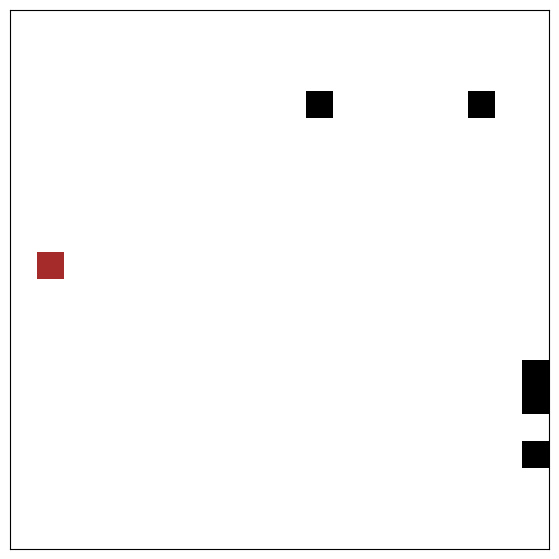

In [2371]:
fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])

cmap = ListedColormap(['white', 'lightblue', 'blue', 'green', 'brown', 'yellow', 'navy', 'midnightblue', 'black'])
numerical_grid = np.array([[cmap.colors.index(color) for color in row] for row in all_grid.iloc[0]['Grid']])
patch = plt.imshow(numerical_grid, cmap=cmap)

def animate(frame):
    current_grid = all_grid.iloc[frame]['Grid']
    numerical_grid = np.array([[cmap.colors.index(color) for color in row] for row in current_grid])
    patch.set_data(numerical_grid)
    return patch

anim = animation.FuncAnimation(fig, animate, frames=MAX_STEPS + 1, interval=100)


In [2372]:
anim